Download the data

In [ ]:
!gdown --id 1O9EHQU5LclBb39oATdWt6eoCG46NeABV
!unzip bankruptcy_data.csv.zip

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1O9EHQU5LclBb39oATdWt6eoCG46NeABV
To: /content/bankruptcy_data.csv.zip
100% 4.86M/4.86M [00:00<00:00, 31.0MB/s]
Archive:  bankruptcy_data.csv.zip
  inflating: data.csv                


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score,accuracy_score, precision_score, recall_score, roc_auc_score 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

In [ ]:
data = pd.read_csv("data.csv")

In [ ]:
pprint({'a':1})

{'a': 1}


In [ ]:
data

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [ ]:
row = data.shape[0]
col = data.shape[1]
print("The number of rows within the dataset are {} and the number of columns is {}".format(row,col))

The number of rows within the dataset are 6819 and the number of columns is 96


Looking for null values

In [ ]:
data.isnull().sum().sort_values(ascending=False).head()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 Total expense/Assets                                       0
 Total income/Total expense                                 0
 Retained Earnings to Total Assets                          0
dtype: int64

## Balancing the Dataset

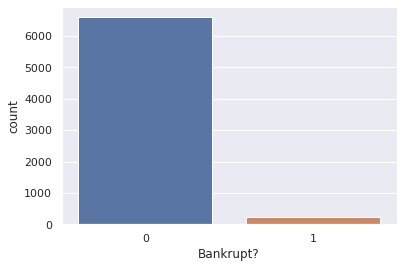

In [ ]:
sns.countplot('Bankrupt?',data=data)

The records are observed to be highly imbalanced. Thus it is necessary to consider balancing the dataset through "Upsampling or Downsampling" techniques.

Using SMOTE to bring balance to the classes

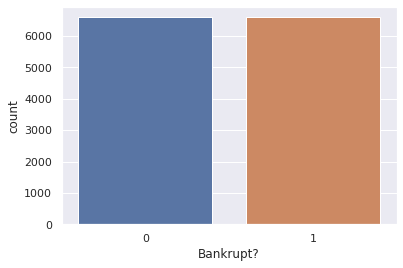

In [ ]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
X = data.drop('Bankrupt?', axis=1)
y = data['Bankrupt?']
X_sm, y_sm = sm.fit_resample(X, y)
sns.countplot(y_sm)

In [ ]:
data[' Revenue per person'].median()

0.0186155134174464

In [ ]:
data[' Revenue per person'].describe()

count    6.819000e+03
mean     2.325854e+06
std      1.366327e+08
min      0.000000e+00
25%      1.043285e-02
50%      1.861551e-02
75%      3.585477e-02
max      8.810000e+09
Name:  Revenue per person, dtype: float64

Looking at the mean and median we chose the following binning 

After our investigation, the annual per capita disposable income of Chinese residents is 18,000 yuan, and the median of Revenue per person in this data set is also 0.018. So we set more than 0.1, that is, an annual income of more than 100,000 yuan, as high income, 0.01 to 0.1 (annual income of 10,000 yuan to 100,000 yuan) as middle income, and 0.01 or less (annual income of less than 10,000 yuan) ) set to low income

In [ ]:
def bin_to(trainy_Rev):
  if trainy_Rev>=0.1:
     trainy_Rev=3 # Rich
     
  elif trainy_Rev<=0.01:
    trainy_Rev=1 # Poor
  else:
    trainy_Rev=2 # Middle Class
  return trainy_Rev

In [ ]:
data[' Revenue per person']

0       0.034164
1       0.006889
2       0.028997
3       0.015463
4       0.058111
          ...   
6814    0.006348
6815    0.016083
6816    0.022097
6817    0.012749
6818    0.002097
Name:  Revenue per person, Length: 6819, dtype: float64

In [ ]:
data[' Revenue per person'] = data[' Revenue per person'].apply(bin_to)

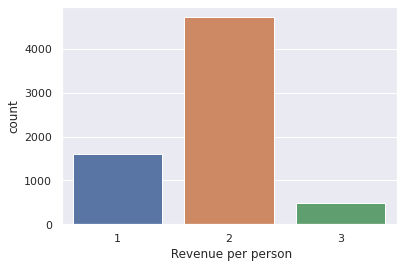

In [ ]:
sns.countplot(' Revenue per person',data=data)


In [ ]:
data[' Revenue per person'].value_counts()

2    4726
1    1611
3     482
Name:  Revenue per person, dtype: int64

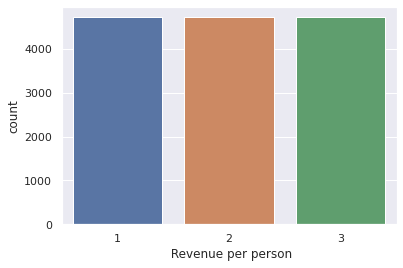

In [ ]:
sm = SMOTE(sampling_strategy='auto', random_state=42)
X = data.drop(' Revenue per person', axis=1)
y = data[' Revenue per person']
X_sm, y_sm = sm.fit_resample(X, y)
sns.countplot(y_sm)

In [ ]:
y_rev, y_bk = data[' Revenue per person'], data['Bankrupt?']

In [ ]:
X = data.drop(columns = [' Revenue per person','Bankrupt?'], axis=1)

In [ ]:
Models = pd.DataFrame(columns=['Algorithm','Model Score','Precision','Recall'])

def train(X, y, Parameters, Model, Modelname):
    
    #Traditional split of the dataset 80% - 20%
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

    #Proportional split of 80% data with respect to the class of the target feature ie. [1,0]
    sf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

    for train_index, test_index in sf.split(x_train, y_train):
        sf_x_train, sf_x_test = X.iloc[train_index], X.iloc[test_index]
        sf_y_train, sf_y_test = y.iloc[train_index], y.iloc[test_index]

    sf_x_train, sf_x_test, sf_y_train, sf_y_test = sf_x_train.values, sf_x_test.values, sf_y_train.values, sf_y_test.values
    
    model_parameter_sm = Parameters

    rand_model = RandomizedSearchCV(Model, model_parameter_sm, n_iter=4)
     
    #Identifying the best parameters through RandomizedSearchCV()
    for train, test in sf.split(sf_x_train, sf_y_train):
        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='auto'), rand_model) 
        fitting_model = pipeline.fit(sf_x_train[train], sf_y_train[train])
        best_model = rand_model.best_estimator_

    #Evaluation with against 20% unseen testing data
    print()
    print("Using Parameters " )
    print(best_model.get_params())
    print()
    print("Evaluation Of Models")  

    sm = SMOTE(sampling_strategy='auto', random_state=42)
    Xsm_train, ysm_train = sm.fit_resample(sf_x_train, sf_y_train)
    
    print()
    print("Random Model Evaluation")  
    
    final_model_sm = rand_model.best_estimator_
    final_model_sm.fit(Xsm_train, ysm_train)

    prediction = final_model_sm.predict(x_test)

    print(classification_report(y_test, prediction))
    
    model = {}
    if len(y.value_counts()) < 3 :
      model['Algorithm'] = Modelname
      model['Model Score'] = str(round((accuracy_score(y_test, prediction )*100),2)) + "%"
      model['Precision'] = round(precision_score(y_test, prediction),2)
      model['Recall'] = round(recall_score(y_test, prediction),2)
      # model['F1 score'] = round(f1_score(y_test, prediction),2)
      # model['ROC-AUC score'] = round(roc_auc_score(y_test, prediction),2)
    else:
      model['Algorithm'] = Modelname
      model['Model Score'] = str(round((accuracy_score(y_test, prediction)*100),2)) + "%"
      model['Precision'] = round(precision_score(y_test, prediction, average="weighted"),2)
      model['Recall'] = round(recall_score(y_test, prediction, average="weighted"),2)
      prediction = final_model_sm.predict_proba(x_test)
      # model['F1 score'] = round(f1_score(y_test, prediction, average="weighted"),2)
      # model['ROC-AUC score'] = round(roc_auc_score(y_test, prediction, average="weighted", multi_class="ovr"),2)
    
    
    return model

In [ ]:
name = "KNN Baseline wrt Bankrupt vs Features"
print(name)
TrainedModel = train(X, y_bk, {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}, KNeighborsClassifier(), name)
Models = Models.append(TrainedModel,ignore_index=True)

KNN Baseline wrt Bankrupt vs Features

Using Parameters 
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 2,
 'p': 2,
 'weights': 'uniform'}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1313
           1       0.58      0.80      0.67        51

    accuracy                           0.97      1364
   macro avg       0.78      0.89      0.83      1364
weighted avg       0.98      0.97      0.97      1364



In [ ]:
name = "KNN Baseline wrt Revenue/Person vs Features"
print(name)
TrainedModel = train(X, y_rev, {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}, KNeighborsClassifier(), name)
Models = Models.append(TrainedModel,ignore_index=True)

KNN Baseline wrt Revenue/Person vs Features

Using Parameters 
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 2,
 'p': 2,
 'weights': 'uniform'}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           1       0.51      0.87      0.65       335
           2       0.92      0.68      0.78       933
           3       0.76      0.83      0.80        96

    accuracy                           0.74      1364
   macro avg       0.73      0.80      0.74      1364
weighted avg       0.81      0.74      0.75      1364



In [ ]:
name = "Logistic Regression Baseline wrt Bankrupt vs Features"
print(name)
TrainedModel = train(X, y_bk, {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, LogisticRegression(solver='liblinear'), name)
Models = Models.append(TrainedModel,ignore_index=True)

Logistic Regression Baseline wrt Bankrupt vs Features

Using Parameters 
{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      1313
           1       0.09      0.47      0.15        51

    accuracy                           0.80      1364
   macro avg       0.53      0.64      0.52      1364
weighted avg       0.94      0.80      0.86      1364



In [ ]:
name = "Logistic Regression Baseline wrt Revenue/Person vs Features"
print(name)
TrainedModel = train(X, y_rev, {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, LogisticRegression(solver='liblinear'), name)
Models = Models.append(TrainedModel,ignore_index=True)

Logistic Regression Baseline wrt Revenue/Person vs Features

Using Parameters 
{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           1       0.35      0.68      0.46       335
           2       0.73      0.25      0.37       933
           3       0.18      0.73      0.29        96

    accuracy                           0.39      1364
   macro avg       0.42      0.55      0.37      1364
weighted avg       0.60      0.39      0.39      1364



In [ ]:
name = "DecisionTree Baseline wrt Bankrupt vs Features"
print(name)
TrainedModel = train(X, y_bk, {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),"min_samples_leaf": list(range(5,7,1))}, DecisionTreeClassifier(), name)
Models = Models.append(TrainedModel,ignore_index=True)


DecisionTree Baseline wrt Bankrupt vs Features

Using Parameters 
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1313
           1       0.20      0.86      0.32        51

    accuracy                           0.86      1364
   macro avg       0.59      0.86      0.62      1364
weighted avg       0.96      0.86      0.90      1364



In [ ]:
name = "DecisionTree Baseline wrt Revenue/Person vs Features"
print(name)
TrainedModel = train(X, y_rev, {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),"min_samples_leaf": list(range(5,7,1))}, DecisionTreeClassifier(), name)
Models = Models.append(TrainedModel,ignore_index=True)

DecisionTree Baseline wrt Revenue/Person vs Features

Using Parameters 
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           1       0.45      0.83      0.59       335
           2       0.87      0.54      0.67       933
           3       0.43      0.73      0.54        96

    accuracy                           0.63      1364
   macro avg       0.58      0.70      0.60      1364
weighted avg       0.74      0.63      0.64      1364



In [ ]:
name = "Random Forest Baseline wrt Bankrupt vs Features"
print(name)
TrainedModel = train(X, y_bk, {"max_depth": [3, 5, 10, None],"n_estimators": [100, 200, 300, 400, 500]},  RandomForestClassifier(), name)
Models = Models.append(TrainedModel,ignore_index=True)

Random Forest Baseline wrt Bankrupt vs Features

Using Parameters 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1313
           1       0.77      0.98      0.86        51

    accuracy                           0.99      1364
   macro avg       0.88      0.98      0.93      1364
weighted avg       0.99      0.99      0.99      1364



In [ ]:
name = "Random Forest Baseline wrt Revenue/Person vs Features"
print(name)
TrainedModel = train(X, y_rev, {"max_depth": [3, 5, 10, None],"n_estimators": [100, 200, 300, 400, 500]},  RandomForestClassifier(), name)
Models = Models.append(TrainedModel,ignore_index=True)

Random Forest Baseline wrt Revenue/Person vs Features

Using Parameters 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           1       0.93      0.92      0.92       335
           2       0.97      0.96      0.96       933
           3       0.87      0.96      0.91        96

    accuracy                           0.95      1364
   macro avg       0.92      0.95      0.93      1364
weighted avg       0.95      0.95      0.95      1364



In [ ]:
# name = "Support Vector Baseline wrt Bankrupt vs Features"
# print(name)
# TrainedModel = train(X, y_bk, {'C': [1,10,20],'kernel': ['rbf','linear']},  SVC(), name)
# Models = Models.append(TrainedModel,ignore_index=True)

In [ ]:
# name = "Support Vector Baseline wrt Revenue/Person vs Features"
# print(name)
# TrainedModel = train(X, y_rev, {'C': [1,10,20],'kernel': ['rbf','linear']},  SVC(), name)
# Models = Models.append(TrainedModel,ignore_index=True)

In [ ]:
pd.set_option('display.max_colwidth', None)
Models.sort_values('Model Score', ascending=False)

,Algorithm,Model Score,Precision,Recall
6,Random Forest Baseline wrt Bankrupt vs Features,98.83%,0.77,0.98
0,KNN Baseline wrt Bankrupt vs Features,97.07%,0.58,0.80
7,Random Forest Baseline wrt Revenue/Person vs Features,94.94%,0.95,0.95
4,DecisionTree Baseline wrt Bankrupt vs Features,86.22%,0.20,0.86
2,Logistic Regression Baseline wrt Bankrupt vs Features,79.91%,0.09,0.47
1,KNN Baseline wrt Revenue/Person vs Features,73.9%,0.81,0.74
5,DecisionTree Baseline wrt Revenue/Person vs Features,62.83%,0.74,0.63
3,Logistic Regression Baseline wrt Revenue/Person vs Features,38.93%,0.60,0.39


In [ ]:
Models1 = pd.DataFrame(columns=['Algorithm','Model Score','Precision','Recall'])

In [ ]:
#Using PCA
n_components = 8
pca = PCA(n_components=n_components)
X_PCA = pca.fit_transform(X)

In [ ]:
X_PCA_df = pd.DataFrame(X_PCA)

In [ ]:
name = f"KNN wrt Bankrupt vs Features Using PCA({n_components} components)"
print(name)
TrainedModel = train(X_PCA_df, y_bk, {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}, KNeighborsClassifier(), name)
Models1 = Models1.append(TrainedModel,ignore_index=True)

KNN wrt Bankrupt vs Features Using PCA(8 components)

Using Parameters 
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 2,
 'p': 2,
 'weights': 'uniform'}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1313
           1       0.57      0.78      0.66        51

    accuracy                           0.97      1364
   macro avg       0.78      0.88      0.82      1364
weighted avg       0.98      0.97      0.97      1364



In [ ]:
name = "KNN wrt Revenue/Person vs Features Using PCA(8 components)"
print(name)
TrainedModel = train(X_PCA_df, y_rev, {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}, KNeighborsClassifier(),name)
Models1 = Models1.append(TrainedModel,ignore_index=True)

KNN wrt Revenue/Person vs Features Using PCA(8 components)

Using Parameters 
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 2,
 'p': 2,
 'weights': 'uniform'}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           1       0.51      0.87      0.64       335
           2       0.92      0.68      0.78       933
           3       0.74      0.82      0.78        96

    accuracy                           0.74      1364
   macro avg       0.72      0.79      0.73      1364
weighted avg       0.81      0.74      0.75      1364



In [ ]:
name = "Logistic Regression PCA wrt Bankrupt vs Features"
print(name)
TrainedModel = train(X_PCA_df, y_bk, {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, LogisticRegression(solver='liblinear'), name)
Models1 = Models1.append(TrainedModel,ignore_index=True)

Logistic Regression PCA wrt Bankrupt vs Features

Using Parameters 
{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           0       0.98      0.51      0.67      1313
           1       0.05      0.71      0.10        51

    accuracy                           0.51      1364
   macro avg       0.52      0.61      0.38      1364
weighted avg       0.94      0.51      0.65      1364



In [ ]:
name = "Logistic Regression PCA wrt Revenue/Person vs Features"
print(name)
TrainedModel = train(X_PCA_df, y_rev, {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, LogisticRegression(solver='liblinear'), name)
Models1 = Models1.append(TrainedModel,ignore_index=True)

Logistic Regression PCA wrt Revenue/Person vs Features

Using Parameters 
{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           1       0.39      0.57      0.46       335
           2       0.78      0.18      0.29       933
           3       0.13      0.92      0.23        96

    accuracy                           0.33      1364
   macro avg       0.43      0.55      0.33      1364
weighted avg       0.64      0.33      0.33      1364



In [ ]:
name = "DecisionTree PCA wrt Bankrupt vs Features"
print(name)
TrainedModel = train(X_PCA_df, y_bk, {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),"min_samples_leaf": list(range(5,7,1))}, DecisionTreeClassifier(), name)
Models1 = Models1.append(TrainedModel,ignore_index=True)


DecisionTree PCA wrt Bankrupt vs Features

Using Parameters 
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           0       0.98      0.48      0.65      1313
           1       0.05      0.73      0.10        51

    accuracy                           0.49      1364
   macro avg       0.52      0.60      0.37      1364
weighted avg       0.94      0.49      0.63      1364



In [ ]:
name = "DecisionTree PCA wrt Revenue/Person vs Features"
print(name)
TrainedModel = train(X_PCA_df, y_rev, {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),"min_samples_leaf": list(range(5,7,1))}, DecisionTreeClassifier(), name)
Models1 = Models1.append(TrainedModel,ignore_index=True)

DecisionTree PCA wrt Revenue/Person vs Features

Using Parameters 
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           1       0.35      0.63      0.45       335
           2       0.77      0.21      0.33       933
           3       0.15      0.80      0.25        96

    accuracy                           0.36      1364
   macro avg       0.42      0.55      0.35      1364
weighted avg       0.62      0.36      0.36      1364



In [ ]:
name = "Random Forest PCA wrt Bankrupt vs Features"
print(name)
TrainedModel = train(X_PCA_df, y_bk, {"max_depth": [3, 5, 10, None],"n_estimators": [100, 200, 300, 400, 500]},  RandomForestClassifier(), name)
Models1 = Models1.append(TrainedModel,ignore_index=True)

Random Forest PCA wrt Bankrupt vs Features

Using Parameters 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1313
           1       0.63      0.80      0.71        51

    accuracy                           0.98      1364
   macro avg       0.81      0.89      0.85      1364
weighted avg       0.98      0.98      0.98      1364



In [ ]:
name = "Random Forest PCA wrt Revenue/Person vs Features"
print(name)
TrainedModel = train(X_PCA_df, y_rev, {"max_depth": [3, 5, 10, None],"n_estimators": [100, 200, 300, 400, 500]},  RandomForestClassifier(), name)
Models1 = Models1.append(TrainedModel,ignore_index=True)

Random Forest PCA wrt Revenue/Person vs Features

Using Parameters 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

           1       0.77      0.80      0.78       335
           2       0.92      0.88      0.90       933
           3       0.72      0.89      0.79        96

    accuracy                           0.86      1364
   macro avg       0.80      0.86      0.83      1364
weighted avg       0.87      0.86      0.86      1364



In [ ]:
Models1.sort_values('Model Score', ascending=False)

,Algorithm,Model Score,Precision,Recall
4,Random Forest PCA wrt Bankrupt vs Features,97.51%,0.63,0.80
6,KNN wrt Bankrupt vs Features Using PCA(8 components),96.99%,0.57,0.78
5,Random Forest PCA wrt Revenue/Person vs Features,86.22%,0.87,0.86
8,KNN wrt Revenue/Person vs Features Using PCA(8 components),73.61%,0.81,0.74
0,Logistic Regression PCA wrt Bankrupt vs Features,51.32%,0.05,0.71
2,DecisionTree PCA wrt Bankrupt vs Features,49.34%,0.05,0.73
3,DecisionTree PCA wrt Revenue/Person vs Features,35.56%,0.62,0.36
1,Logistic Regression PCA wrt Revenue/Person vs Features,32.7%,0.64,0.33


In [ ]:
Models.sort_values('Model Score', ascending=False)

,Algorithm,Model Score,Precision,Recall
6,Random Forest Baseline wrt Bankrupt vs Features,98.83%,0.77,0.98
0,KNN Baseline wrt Bankrupt vs Features,97.07%,0.58,0.80
7,Random Forest Baseline wrt Revenue/Person vs Features,94.94%,0.95,0.95
4,DecisionTree Baseline wrt Bankrupt vs Features,86.22%,0.20,0.86
2,Logistic Regression Baseline wrt Bankrupt vs Features,79.91%,0.09,0.47
1,KNN Baseline wrt Revenue/Person vs Features,73.9%,0.81,0.74
5,DecisionTree Baseline wrt Revenue/Person vs Features,62.83%,0.74,0.63
3,Logistic Regression Baseline wrt Revenue/Person vs Features,38.93%,0.60,0.39


In [ ]:
Models

,Algorithm,Model Score,Precision,Recall
0,KNN Baseline wrt Bankrupt vs Features,97.07%,0.58,0.80
1,KNN Baseline wrt Revenue/Person vs Features,73.9%,0.81,0.74
2,Logistic Regression Baseline wrt Bankrupt vs Features,79.91%,0.09,0.47
3,Logistic Regression Baseline wrt Revenue/Person vs Features,38.93%,0.60,0.39
4,DecisionTree Baseline wrt Bankrupt vs Features,86.22%,0.20,0.86
5,DecisionTree Baseline wrt Revenue/Person vs Features,62.83%,0.74,0.63
6,Random Forest Baseline wrt Bankrupt vs Features,98.83%,0.77,0.98
7,Random Forest Baseline wrt Revenue/Person vs Features,94.94%,0.95,0.95


In [ ]:
Models1.reindex([6,8,0,1,2,3,4,5])

,Algorithm,Model Score,Precision,Recall
6,KNN wrt Bankrupt vs Features Using PCA(8 components),96.99%,0.57,0.78
8,KNN wrt Revenue/Person vs Features Using PCA(8 components),73.61%,0.81,0.74
0,Logistic Regression PCA wrt Bankrupt vs Features,51.32%,0.05,0.71
1,Logistic Regression PCA wrt Revenue/Person vs Features,32.7%,0.64,0.33
2,DecisionTree PCA wrt Bankrupt vs Features,49.34%,0.05,0.73
3,DecisionTree PCA wrt Revenue/Person vs Features,35.56%,0.62,0.36
4,Random Forest PCA wrt Bankrupt vs Features,97.51%,0.63,0.80
5,Random Forest PCA wrt Revenue/Person vs Features,86.22%,0.87,0.86
